# Packaging and Deploying our ML model to our edge devices

In this exercise, we will:
 - Compile the model using SageMaker Neo
 - Create a model component using SageMaker Edge Manager+ Greengrass V2 integration
 - Setup Greengrass V2
 - Create inference component using Greengrass V2

## Prerequisites

First, let us restore variables stored in the previous exercise

In [ ]:
%store -r project_id
%store -r estimator_output_path
%store -r training_job_name
%store -r n_features

In [ ]:
import sagemaker
import time
import boto3
import json
import uuid

s3_client = boto3.client('s3')
sm_client = boto3.client('sagemaker')

sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
bucket_name = 'sagemaker-wind-turbine-farm-%s' % project_id

prefix='wind_turbine_anomaly'

### Compiling our ML model

### Invoking SageMaker NEO to compile the trained model

In [ ]:
compilation_job_name = 'wind-turbine-anomaly-%d' % int(time.time()*1000)

sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': '%s%s/output/model.tar.gz' % (estimator_output_path, training_job_name),
        'DataInputConfig': '{"input0":[1,%d,10,10]}' % n_features,
        'Framework': 'PYTORCH'
    },
    OutputConfig={
        'S3OutputLocation': 's3://%s/wind_turbine/optimized/' % sagemaker_session.default_bucket(),        
        'TargetPlatform': { 'Os': 'LINUX', 'Arch': 'X86_64' }
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }
)
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(5)

### Building the Deployment Package using SageMaker Edge Manager, including the Greengrass Componenent

At first, It will sign the model and create a deployment package with:
 - The optimized model
 - Model Metadata
 - SageMaker NEO runtime (dlr)
 
To create model as a Greengrass component, we add two new paramters to the `OutputConfig`: 
- `PresetDeploymentType`
- `PresetDeploymentConfig` 

You also need to increase the component version every time you run the packaging job (in the example below we use the model_version for traceability), since Greengrass components are immutable. Alternatively, you can delete the existing component version before re-running the packagin job.

In [ ]:
import time
model_version = '1.0.0'
model_name = 'WindTurbineAnomalyDetection'
edge_packaging_job_name='wind-turbine-anomaly-%d' % int(time.time()*1000)
component_name = 'aws.samples.windturbine.model'
component_version = '1.0.0' # increase the version every time you run this cell

resp = sm_client.create_edge_packaging_job(
    EdgePackagingJobName=edge_packaging_job_name,
    CompilationJobName=compilation_job_name,
    ModelName=model_name,
    ModelVersion=model_version,
    RoleArn=role,
    OutputConfig={
        'S3OutputLocation': 's3://%s/%s/model/' % (bucket_name, prefix),
        "PresetDeploymentType": "GreengrassV2Component",
        "PresetDeploymentConfig": json.dumps(
            {"ComponentName": component_name, "ComponentVersion": component_version}
        ),
    }
)

while True:
    resp = sm_client.describe_edge_packaging_job(EdgePackagingJobName=edge_packaging_job_name)    
    if resp['EdgePackagingJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['EdgePackagingJobStatus'], compilation_job_name)
        break
    time.sleep(5)

Let us fetch the IoT thing group name as we would need it while executing the next cell.

In [ ]:
account_id = sagemaker_session.account_id()
region = sagemaker_session.boto_region_name

iot_client = boto3.client('iot')
thing_groups = iot_client.list_thing_groups(namePrefixFilter='WindTurbineFarm-'+project_id)
wind_turbine_thing_group_arn = thing_groups['thingGroups'][0]['groupArn']
print("wind turbinethinggroup arn is {}".format(wind_turbine_thing_group_arn))

### Print the SageMake Execution Role

For executing the next section **Run the IoT Core Devices**, we need the SageMake Execution role. The next cell prints the role. Copy it as you would need it later.

In [ ]:
role

### Run the IoT Core Devices

Execute the cloudformation template by clicking on the button below:    


[![Launch Stack](https://s3.amazonaws.com/cloudformation-examples/cloudformation-launch-stack.png)](https://console.aws.amazon.com/cloudformation/home#/stacks/new?stackName=IoTCoreDevicesStack&templateURL=https://s3.amazonaws.com/ee-assets-prod-us-east-1/modules/23c647abc48b4d8292d5da1af579c199/v1/greengrass_edge_devices_ec2.yml)       


 The template requires the following parameters:    
  1. Stack name.   
  2. AMI id.   
  3. SageMaker Execution role
  4. SageMakerEdgeManagerDeviceFleetPolicyArn.    
  5. IoT Thing Group Name       

Check the screenshot below for reference values:    

![cfn_core_devices](../../../imgs/ggv2_lab3_cfn_core_devices.png)

For this workshop, You dont need to change the `AMI` id and `SageMakerEdgeManagerDeviceFleetPolicyArn` values. But if you wish to use some other AMI id or any other Edge Device Fleet, you can do so.         

**NOTE: Use the same IoT Thing Group name which has been created as part of this SageMaker Project.**

This template will create 5 EC2 instances which act as IoT core devices. Once the stack gets created successfully, also ensure that the Edge devices(EC2 instances) are running and that Greengrass V2 software is running on those edge devices successfully.

You can check this by:
- Going to IoT Core console:
- From left pane, Click on Greengrass->Core devices.
- 5 edge devices should be listed as `Healthy`. These edge devices are the same Ec2 instances which we spun up as part of cfn template.
- Click on instances from left pane, it shows currently running instances. You see 5 EC2 instances mimicking 5 IoT Greengrass core devices.(screenshot below):

![ggv2_edge_devices.png](../../../imgs/ggv2_lab3_iot_core_devices_healthy.png)


Once the core devices show as `Healthy`, also connect to any of the EC2 instance from the EC2 console.

- Select one of the instance and click `Connect`
- Choose Session Manager option and click `Connect`. It would open an SSH session to the EC2 instance. Once the session is established successfully, run the following command:
   `sudo systemctl status greengrass.service`
- If Greengrass v2 is running successfully, you would see output similar to the screenshot below. If not, check the `/var/log/cloud-init-output.log` in the EC2 instance to verify if Greengrass V2 installed correctly or not.

![ggv2_is_running](../../../imgs/ggv2_lab3_core_device_is_running.png)

Repeat the above exercise for all the instances to verify if greengrass v2 is running on all core devices(EC2 instances).
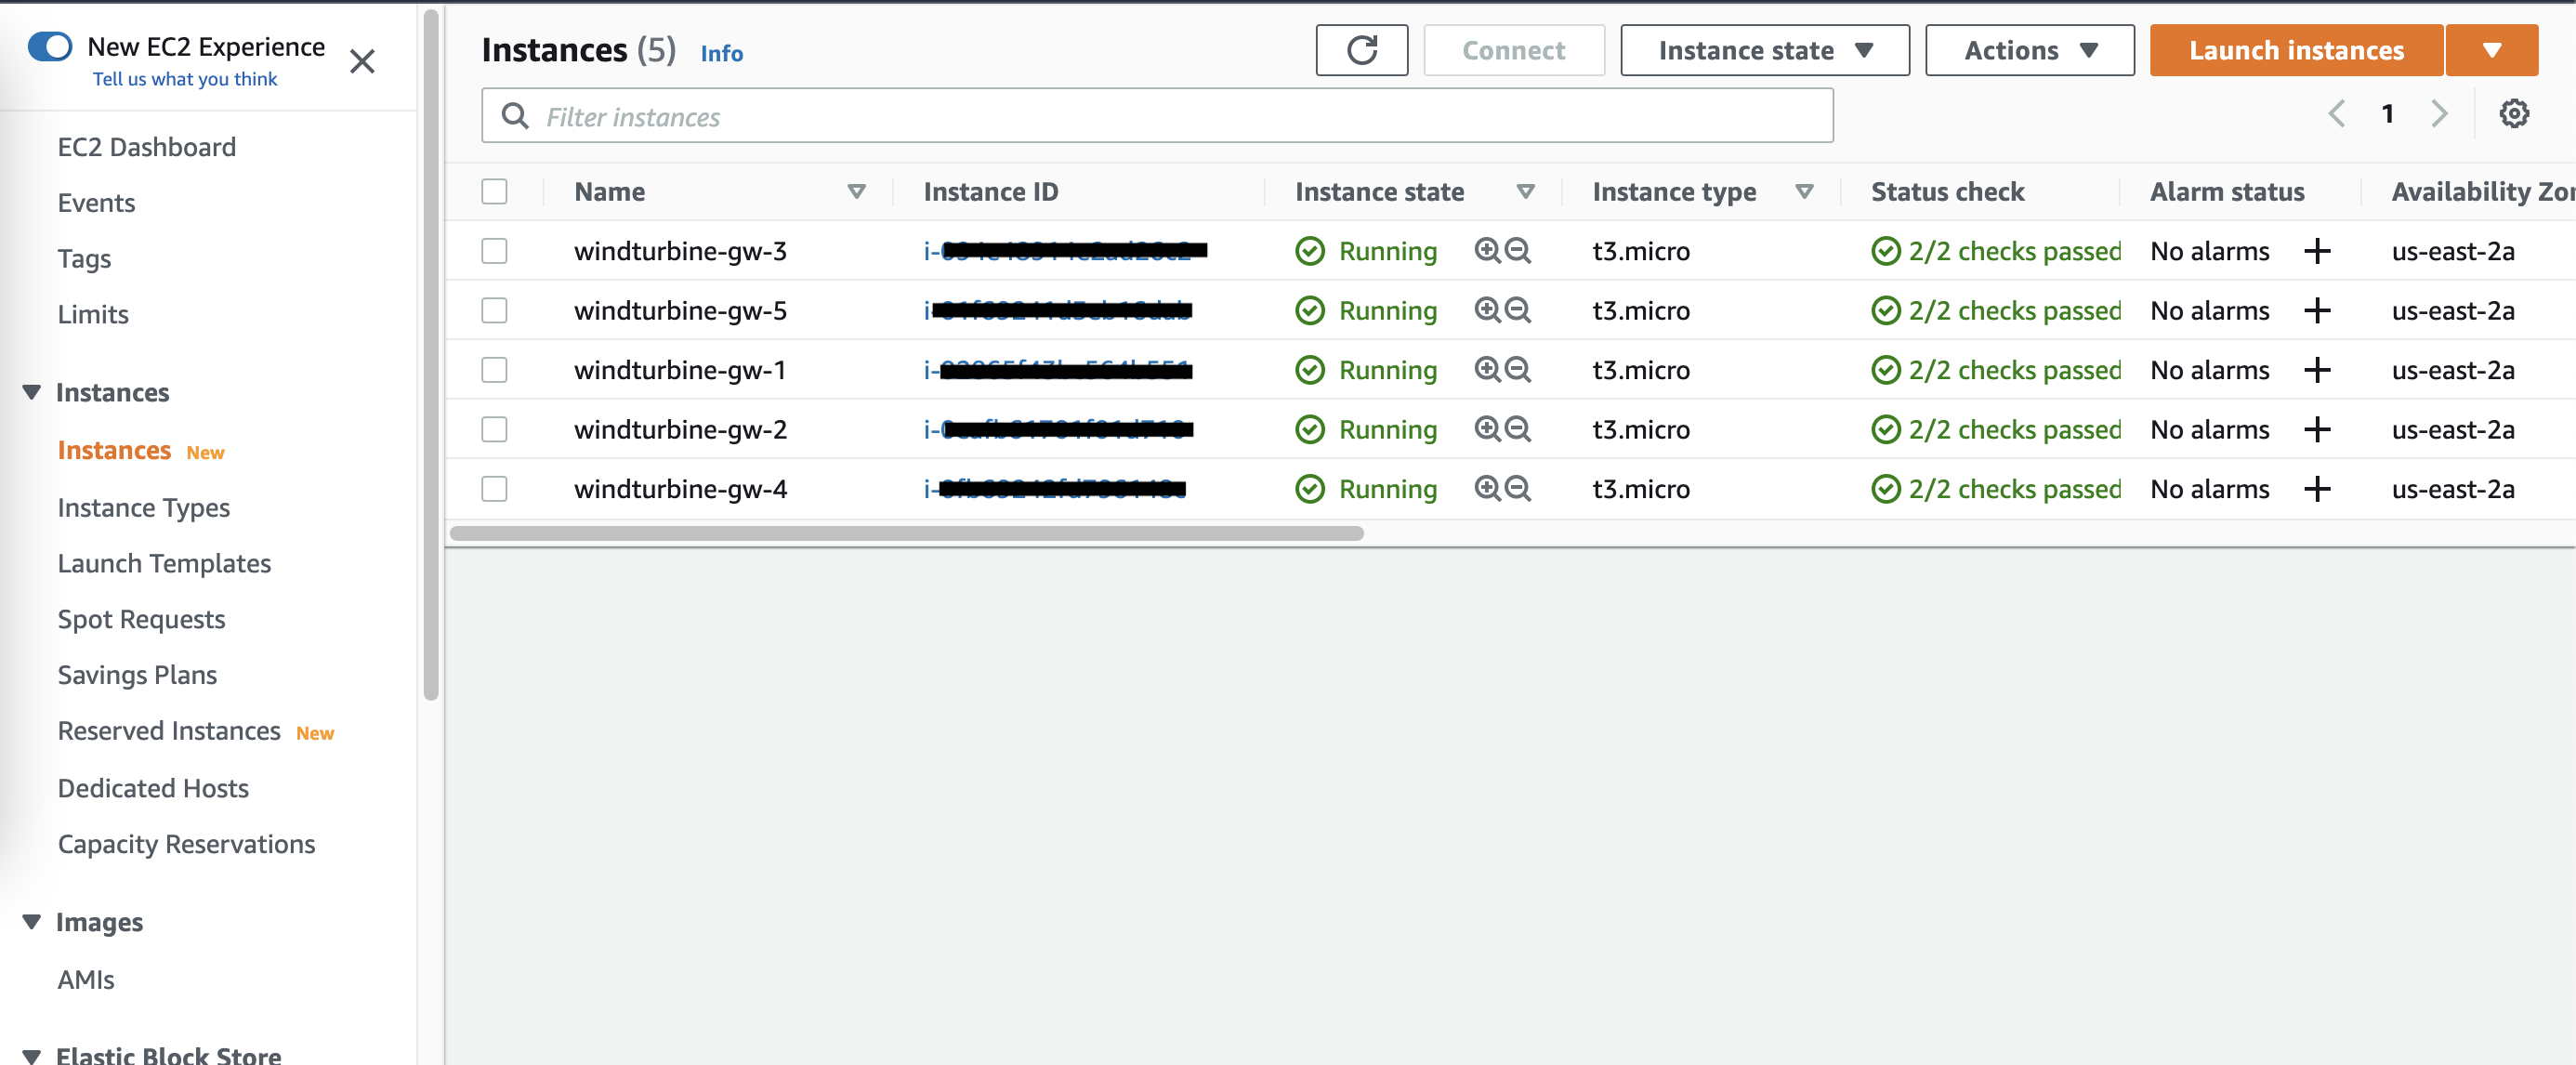

## Deploy using Greengrass V2

Alright, its time to introduce Greengrass V2 concepts.

- __Greengrass core device__ : A device that runs the AWS IoT Greengrass Core software. A Greengrass core device is an AWS IoT thing.

- __Greengrass client device__ : A device that connects to and communicates with a Greengrass core device over MQTT. A Greengrass client device is an AWS IoT thing.

- __Greengrass component__ : A software module that is deployed to and runs on a Greengrass core device. All software that is developed and deployed with AWS IoT Greengrass is modeled as a component.

- __Deployment__ : The process to send components and apply the desired component configuration to a destination target device, which can be a single Greengrass core device or a group of Greengrass core devices.

- __AWS IoT Greengrass Core software__ : The set of all AWS IoT Greengrass software that you install on a core device.

To know more, check out [How AWS IoT Greengrass works](https://docs.aws.amazon.com/greengrass/v2/developerguide/how-it-works.html)



In this workhshop, we are using the below architecture.


## Solution Architecture

![arch](../../../imgs/ggv2_lab3_main_arch.png)

Let us understand the architecture components:

1. __Greengrass core devices__ : We are running 5 EC2 instances and running greengrass core software there. These 5 EC2 instances act as Greengrass core devices. Each core device runs  the following:

  - The Greengrass core runtime in which the whole application runs.

  - SageMaker Edge Manager Agent deployed as a Greengrass V2 component. This is a public component provided by Greengrass V2. Using this, you dont need to separately run your own edge manager agent.

  - The Anomaly detection ML model, deployed as Greengrass V2 component. This the component, we will create and make it available in IoT Greengrass. 
  
  - The inference application, deployed as Greengrass V2 componentn. This component contains the inference code which makes prediction if a turbine reading is Anomaly or not. This component is named as `aws.samples.turbine.detector`. This talks to a single turbine running in the simulator, over IoT core MQTT.

Each Greengrass core device contains a full deployment of the components discussed above.


2. __Simulator__ : The simulator runs the turbines and talk to Greengrass core devies via IoT core MQTT. It uses IAM authentication mode and uses the current execution role to connect and publish/subscribe to MQTT topics. In this exercise we will run the simulator in the notebook.


## Deploy the inference component

Using Greengrass we are going to deploy the application and the model to the edge devices. We follows these steps:
 1. Create a greengrass component for the inference application (detector.zip)
 2. Create a greengrass deployment which deploys the following:    
     2.a SageMaker Edge Manager Greengrass component    
     2.b Anomaly Detection ML model    
     2.c Anomaly detector inference app    
     2.d greengrass cli(only needed for debugging purposes)    


### 1. Create a greengrass component for the inference application

As a pre-requisite, first install zip utility as we will zip all the files together to create a single inference artifact.

In [ ]:
!apt update && apt install zip

Now we create our inference component. 

All the files needed for the inference component are available at `/artifacts/aws.samples.windturbine.detector/1.0.0`. The reason for creating this type of folder structure is explained at : [Create custom AWS IoT Greengrass components](https://docs.aws.amazon.com/greengrass/v2/developerguide/create-components.html). 

Let us understand what does each file do:
- [run.py](artifacts/aws.samples.windturbine.detector/1.0.0/run.py) : Main application that launches the component

- [agent_pb2_grpc.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/agent_pb2_grpc.py), [agent_pb2.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/agent_pb2.py): Python stubs generated by the protobuf compiler.

- [edgeagentclient.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/edgeagentclient.py) : Client that communicates with SageMaker Edge Agent, using protobuf/gRPC.

- [ggv2_client.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/ggv2_client.py) : Greengrass IoT core Client for connecting to IoT MQTT for publishing/subscribing to topics.

- [messaging_client.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/messaging_client.py) : Messaging client taking the data from inference application and using `ggv2_client` to publish/subscribe to the messages.


- [util.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/util.py) : Containing some generic utility methods used by the inference app.

- [windturbine.py](artifacts/aws.samples.windturbine.detector/1.0.0/inference/windturbine.py) : The inference app for each turbine.

### Zip all the files together to create the inference artifact.

Now we will zip all the files mentioned above, together, and upload them to S3 location. This zip file will be supplied inside Greengrass core device to deploy the inference component.

We also added another folder named `statistics` to the zip. The files under `statistics` folder is needed by the inference app to compute features at runtime.

In [ ]:
!cd artifacts/aws.samples.windturbine.detector/1.0.0 && zip -r ../../../detector.zip *

### Upload inference artifact to S3

Upload the detector.zip to the S3 bucket in the same region where you are configuring Greengrass.

In [ ]:
!aws s3 cp detector.zip s3://{bucket_name}/aws.samples.windturbine.detector/1.0.0/detector.zip

### Create the inference component

Now, lets create the inference component. Greengrass V2 requires a recipe to be supplied which contains build, install and other lifecycle instruction and configuration for the component. The recipe can be either in YAML or JSON format.

The inference component defines a dependency on:
 - [SageMaker Edge Manager](https://docs.aws.amazon.com/greengrass/v2/developerguide/sagemaker-edge-manager-component.html)
 - The Greengrass model component we created in the beginning of this notebook.
 
It also means you don't need to run the edge manager agent separately in your core devices where the inference happens. Greengrass takes care of that.

The recipe is present under the recipe folder. For more details on how to create a recipe, please check out [AWS IoT Greengrass component recipe reference](https://docs.aws.amazon.com/greengrass/v2/developerguide/component-recipe-reference.html)


In [ ]:
ggv2_client = boto3.client('greengrassv2')

with open('recipes/aws.samples.windturbine.detector-recipe.json') as f:
    recipe = f.read()
recipe = recipe.replace('_BUCKET_', bucket_name)
ggv2_client.create_component_version(inlineRecipe=recipe)


## Deploy the application to the devices

Now that the component has been created, we can deploy it to the devices. 

During the setup of this workshop we have created 5 EC2 instances running AWS IoT Greengrass. You can think of these instances as the phyisical devices or gateways that are controlling your wind turbine(s). Using AWS IoT Greengrass we can deploy and update the software running on the devices, collect logs and monitoring the device operations.

To deploy the SageMaker Edge Manager component, it needs to know the SageMaker Edge Device Fleet name and also the s3 output bucket name.

We also need to know the IoT thing group name as we will deploy the components all at once to all the core devices.

In [ ]:
device_fleets = sm_client.list_device_fleets(NameContains='wind-turbine-farm-'+project_id)
wind_turbine_device_fleet_name = device_fleets['DeviceFleetSummaries'][0]['DeviceFleetName']
print("sagemaker edge manager device fleet name is {}".format(wind_turbine_device_fleet_name))

Make sure the edge device fleet output location is correct.

In [ ]:
update_device_fleet_response = sm_client.update_device_fleet(
    DeviceFleetName=wind_turbine_device_fleet_name,
    OutputConfig={
        'S3OutputLocation': 's3://'+bucket_name,
    },
)

update_device_fleet_response

### 2. Create Greengrass deployment

Now lets create a deployment. The following components are deployed in this deployment:    
1. greengrass cli: latest version
2. The Edge manager component: needs the name of sagemaker edge device fleet and fleet's output bucket location.
3. inferece detector app: needs the component version(update it for every subsequent update to this component)
4. Anomaly detection ML model: needs the component version(update it for every subsequent update to this component)

In [ ]:
component_version = '1.0.0'

ggv2_deployment = ggv2_client.create_deployment(
    targetArn=wind_turbine_thing_group_arn,
    deploymentName="Deployment for " + project_id,
    components={
        "aws.greengrass.Cli": {
            "componentVersion": "2.5.4"
            },
        "aws.greengrass.SageMakerEdgeManager": {
            "componentVersion": "1.1.0",
            "configurationUpdate": {
                "merge": json.dumps({"DeviceFleetName":wind_turbine_device_fleet_name,"BucketName":bucket_name})
            },
            "runWith": {}
        },
        "aws.samples.windturbine.detector": {
            "componentVersion": component_version
        },
        "aws.samples.windturbine.model": {
            "componentVersion": component_version
        }
        })

deployment_id = ggv2_deployment['deploymentId']
iot_job_id = ggv2_deployment['iotJobId']

print("The deployment job id is: {}".format(iot_job_id))

### Wait for deployment to complete

The deployment to all the edge devices in the fleet will take few minutes. We can check the status of the deployment by using the code in the below cell


In [ ]:
num_of_successful_deployed_thing = iot_client.describe_job(jobId=iot_job_id)['job']['jobProcessDetails']['numberOfSucceededThings']

while num_of_successful_deployed_thing < 5:
    print("Deployment to thing group still in progress, pausing for 30 seconds")
    time.sleep(30)
    num_of_successful_deployed_thing = iot_client.describe_job(jobId=iot_job_id)['job']['jobProcessDetails']['numberOfSucceededThings']
    
print("All deployments active now !!")


 Store the below variables as they will be needed in the next notebook

In [ ]:
%store project_id
%store deployment_id

Note that the above cell only shows that that whatever we asked greengrass to deploy,  it did that successfully without any errors. 

To know whether the core device is running the detector components as expected, SSH into the EC2 instances via [Session Manager](https://docs.aws.amazon.com/systems-manager/latest/userguide/session-manager.html) and running the following command:    

`sudo tail -1000f /greengrass/v2/logs/aws.samples.windturbine.detector.log`

if you see a messaging at the end of the log saying: `waiting for data...`, it means the deployment of the inference component is successful and is reay to accept data from the wind turbines.

Alright! Now, You can start the Exercise #4: Run a simulated fleet of wind turbines and edge devices. Predict anomalies
 
 > [Exercise 04](../../04-Run-Fleet/greengrass-v2/04-run-fleet-ggv2.ipynb)